# Bootstrap demo: multivariable KDE-resampling

##### sample code to demonstrate the functionality of multi-variate KDE-resampling for the WUS forest mortality bootstrap

The overall goal of using a Kernel Density Estimator (KDE) to resample control pixels is to create a set of control pixels which have a similar distribution of key landscape variables as the mortality pixels. There are several key considerations here:

1. Since the goal is to match distributions, we can use the Kolmogorov-Smirnov (K-S) statistical test which tests whether two samples are likely to have been drawn from the same distribution. However, the effectiveness of this process depends on the number of random draws (sample size) from the control.  Even for two sets of values randomly drawn from the same distribution, a large enough sample size from one of the distributions will eventually convince the K-S test that the two sets are different. We must test a variety of sample sizes to find how many random draws is too many.

2. When we are combining many variables to be fit/matched by their KDEs, or if the mortality pixel count is small, we might limit ourselves to a very small remaining pool of control pixels. It's important to understand how the filtering influences the selection of these control pixels, their geographic distribution, etc.

3. Both of these considerations will vary depending on the set of mortality pixels we begin with for defining the KDEs. Because we are curious about the analysis' sensitivity to the severity of mortality, we should test the first two considerations for a variety of input mortality pixels.


#### In this demo we will specifically focus on consideration number 1 (effect of control resample size on the appropriateness of selected distributions for the tested variables).
Consideration number 3 can be tested by modifying the path of the mortality pixels in the code below

### Variables used for KDE-resampling:
- NASA SRTM elevation
- MODIS LAI (July mean)
- Tree Canopy Cover (TCC) from the National Land Cover Database (NLCD).

Preliminary setup - load packages, define filepaths, functions, global variables, etc.

In [1]:
#########################################
# Load packages
#########################################

import os  # operating system library
import sys

# numerical/data management packages
import numpy as np
import xarray as xr  # for multi dimensional data
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
# from sklearn.neighbors import KernelDensity

from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# plotting packages
from matplotlib import pyplot as plt  # primary plotting module
import cartopy.crs as ccrs  # spatial plotting library 
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks

#########################################
# Define Global Filepaths
#########################################

# Elevation, Tree Canopy Cover and LAI datasets
elev_file = 'include/SRTM_DEM_05d_WUS.nc'
TCC_file = 'include/NLCD_TCC_05d_WUS_2021.nc'
LAI_July_file = 'include/MODIS_LAI_WUS_05d_2011-2023_July_mean.nc'


# mortality/control shapefiles
control_polygon_filepath = 'include/control_pixels.shp'
mortality_polygon_filepath = 'include/mortality_pixels_gt40p.shp' # MODIFY THIS TO SELECT A DIFFERENT THRESHOLD OF MORTALITY SEVERITY

########################################
# Define Global Variables and constants
#########################################

elevation_bin = 100 # meters
elevation_range = np.linspace(0, 4000, 1000)
LAI_bin = 0.25 # unitless
LAI_range = np.linspace(0, 8, 1000)
TCC_bin = 5 # percent
TCC_range = np.linspace(-20, 120, 1000)

control_sample_sizes = np.arange(10, 220, 20) 

#########################################
# Define Global Functions
#########################################

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'

#########################################
# Define map parameters 
#########################################

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 1  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in


### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())
tiler_zoom = 7  # define a zoom level of detail
extent =  [-125, -118, 36, 44]  # [minx, maxx, miny, maxy], bounds for western US


#### Load datasets and plot maps to visualize

In [2]:
# Load SRTM elevation
elev_rxr = xr.open_dataset(elev_file).squeeze('band').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'])
elev_rxr.rio.write_crs(4326, inplace = True) # specify WGS84 as CRS

# Load MODIS LAI July means
LAI_rxr = xr.open_dataarray(LAI_July_file).sortby(['x', 'y']) # Assume grid matches with elevation dataset (already checked)
LAI_rxr.rio.write_crs(4326, inplace = True) # specify WGS84 as CRS

# Load NLCD Tree Canopy Cover
TCC_rxr = xr.open_dataset(TCC_file).squeeze('band').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y']) # Assume grid matches with elevation dataset (already checked)
TCC_rxr.rio.write_crs(4326, inplace = True) # specify WGS84 as CRS

# Load mortality pixels shapefile
mortality_polygon_gdf = gpd.read_file(mortality_polygon_filepath)
mortality_polygon_geom = mortality_polygon_gdf.geometry.apply(mapping)
num_mortality_pixels = len(mortality_polygon_gdf)

# load control pixels shapefile
control_polygon_gdf = gpd.read_file(control_polygon_filepath)
control_polygon_geom = control_polygon_gdf.geometry.apply(mapping)
num_control_pixels = len(control_polygon_geom)

# Clip datasets to mortality and control domains
elev_rxr_mortality_clip = elev_rxr.rio.clip(mortality_polygon_geom, crs=4326) # filter for disturb domain
elev_rxr_control_clip = elev_rxr.rio.clip(control_polygon_geom, crs=4326) # filter for healthy domain
LAI_rxr_mortality_clip = LAI_rxr.rio.clip(mortality_polygon_geom, crs=4326) # filter for disturb domain
LAI_rxr_control_clip = LAI_rxr.rio.clip(control_polygon_geom, crs=4326) # filter for healthy domain
TCC_rxr_mortality_clip = TCC_rxr.rio.clip(mortality_polygon_geom, crs=4326) # filter for disturb domain
TCC_rxr_control_clip = TCC_rxr.rio.clip(control_polygon_geom, crs=4326) # filter for healthy domain

# define the healthy domain dataset shape (should be the same for all datasets)
orig_dataset_shape = elev_rxr_control_clip.elevation.shape


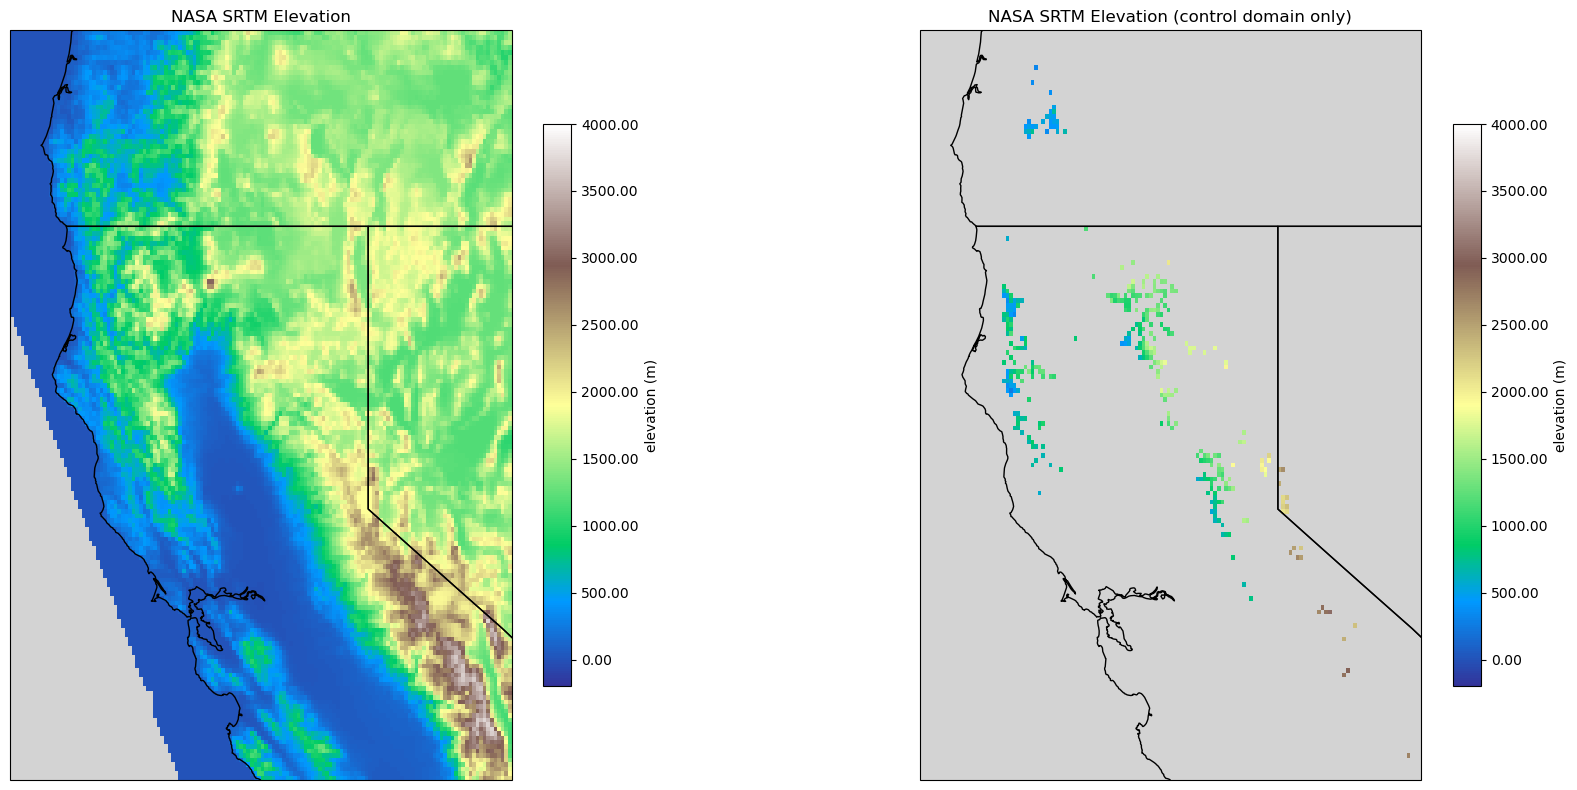

In [3]:
# plot Elevation maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': crs})
ax1.set_extent(extent, crs=transform)
ax2.set_extent(extent, crs=transform)

# Plot full dataset
ax1.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
elev_rxr.elevation.plot(ax=ax1, transform=transform, alpha=alpha, 
                  cmap='terrain', vmin=-200, vmax=4000,
                  cbar_kwargs={'orientation': 'vertical',
                            'pad': 0.03,
                            'label': 'elevation (m)',
                            'shrink': 0.75,
                            'format': FFmt(z_axis_formatter)})
ax1.set_title('NASA SRTM Elevation')
ax1.patch.set_facecolor('lightgray')

# Plot dataset cropped to control domain
ax2.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
elev_rxr_control_clip.elevation.plot(ax=ax2, transform=transform, alpha=alpha, 
                            cmap='terrain', vmin=-200, vmax=4000,
                            cbar_kwargs={'orientation': 'vertical',
                                      'pad': 0.03,
                                      'label': 'elevation (m)',
                                      'shrink': 0.75,
                                      'format': FFmt(z_axis_formatter)})
ax2.set_title('NASA SRTM Elevation (control domain only)')
ax2.patch.set_facecolor('lightgray')

# Show plot
plt.tight_layout()
plt.show()

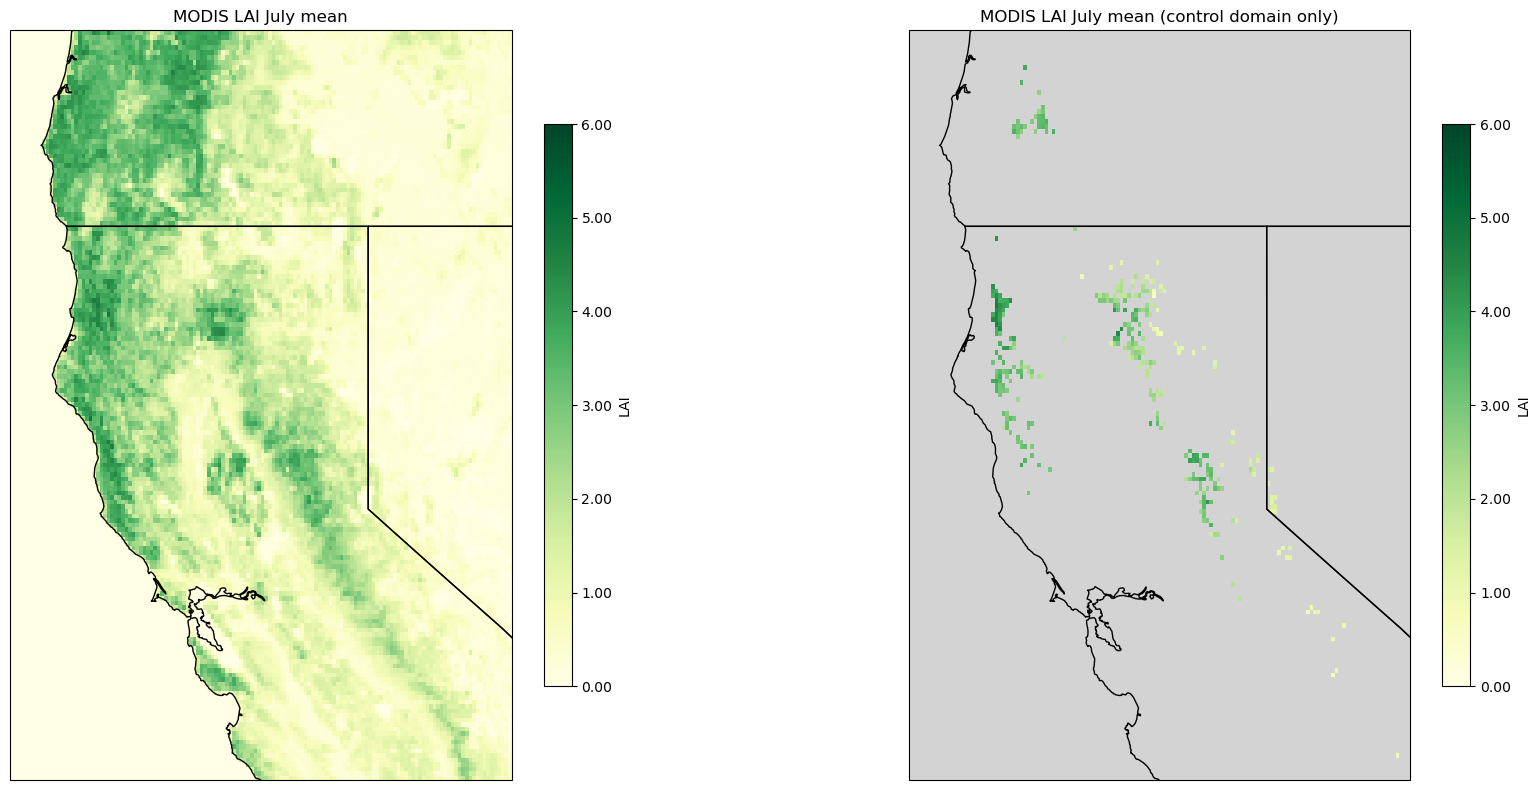

In [5]:
# plot LAI maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': crs})
ax1.set_extent(extent, crs=transform)
ax2.set_extent(extent, crs=transform)

# Plot full dataset
ax1.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
LAI_rxr.plot(ax=ax1, transform=transform, alpha=alpha, 
                  cmap='YlGn', vmin=0, vmax=6,
                  cbar_kwargs={'orientation': 'vertical',
                            'pad': 0.03,
                            'label': 'LAI',
                            'shrink': 0.75,
                            'format': FFmt(z_axis_formatter)})
ax1.set_title('MODIS LAI July mean')
ax1.patch.set_facecolor('lightgray')

# Plot dataset cropped to control domain
ax2.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
LAI_rxr_control_clip.plot(ax=ax2, transform=transform, alpha=alpha, 
                            cmap='YlGn', vmin=0, vmax=6,
                            cbar_kwargs={'orientation': 'vertical',
                                      'pad': 0.03,
                                      'label': 'LAI',
                                      'shrink': 0.75,
                                      'format': FFmt(z_axis_formatter)})
ax2.set_title('MODIS LAI July mean (control domain only)')
ax2.patch.set_facecolor('lightgray')

# Show plot
plt.tight_layout()
plt.show()


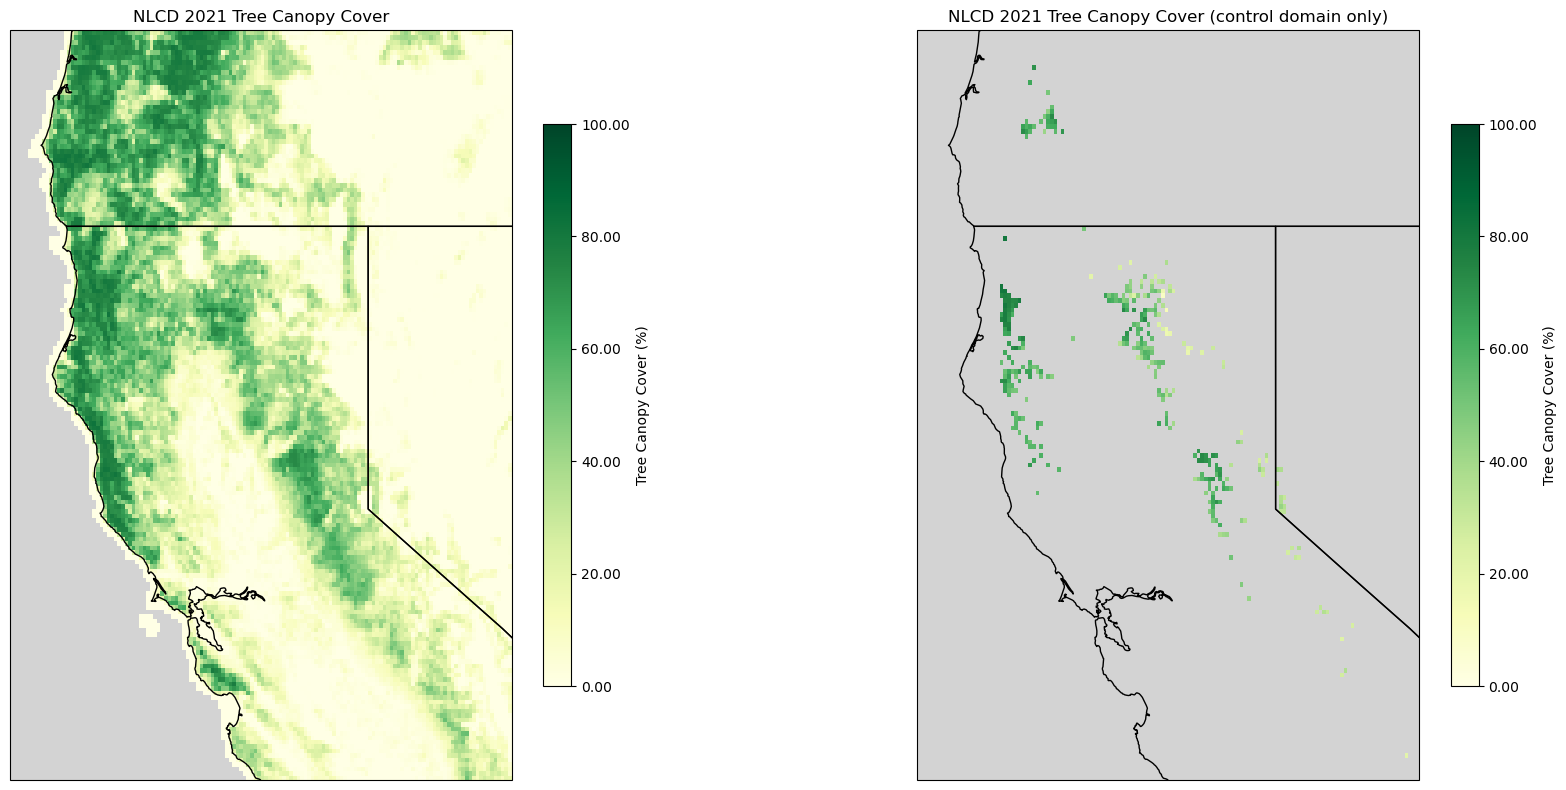

In [6]:
# plot Tree Canopy Cover maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), subplot_kw={'projection': crs})
ax1.set_extent(extent, crs=transform)
ax2.set_extent(extent, crs=transform)

# Plot full dataset
ax1.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
TCC_rxr.tree_canopy_cover.plot(ax=ax1, transform=transform, alpha=alpha, 
                  cmap='YlGn', vmin=0, vmax=100,
                  cbar_kwargs={'orientation': 'vertical',
                            'pad': 0.03,
                            'label': r'Tree Canopy Cover (%)',
                            'shrink': 0.75,
                            'format': FFmt(z_axis_formatter)})
ax1.set_title('NLCD 2021 Tree Canopy Cover')
ax1.patch.set_facecolor('lightgray')

# Plot dataset cropped to control domain
ax2.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)
TCC_rxr_control_clip.tree_canopy_cover.plot(ax=ax2, transform=transform, alpha=alpha, 
                            cmap='YlGn', vmin=0, vmax=100,
                            cbar_kwargs={'orientation': 'vertical',
                                      'pad': 0.03,
                                      'label': r'Tree Canopy Cover (%)',
                                      'shrink': 0.75,
                                      'format': FFmt(z_axis_formatter)})
ax2.set_title('NLCD 2021 Tree Canopy Cover (control domain only)')
ax2.patch.set_facecolor('lightgray')

# Show plot
plt.tight_layout()
plt.show()



##### Process data for bootstrapping

In [4]:
# Flatten the datasets
elev_mortality_flat = elev_rxr_mortality_clip.elevation.data.flatten()
elev_control_flat = elev_rxr_control_clip.elevation.data.flatten()
LAI_mortality_flat = LAI_rxr_mortality_clip.data.flatten()
LAI_control_flat = LAI_rxr_control_clip.data.flatten()
TCC_mortality_flat = TCC_rxr_mortality_clip.tree_canopy_cover.data.flatten()
TCC_control_flat = TCC_rxr_control_clip.tree_canopy_cover.data.flatten()

# Get indices of non-NaN values - Elev
non_nan_indices_disturb = ~np.isnan(elev_mortality_flat)
non_nan_indices_healthy = ~np.isnan(elev_control_flat)
# Filter the datasets to include only non-NaN values
elev_mortality_non_nan = elev_mortality_flat[non_nan_indices_disturb]
elev_control_non_nan = elev_control_flat[non_nan_indices_healthy]
elev_control_mean = np.mean(elev_control_non_nan) # get mean for later scaling

# Get indices of non-NaN values - LAI
non_nan_indices_disturb = ~np.isnan(LAI_mortality_flat)
non_nan_indices_healthy = ~np.isnan(LAI_control_flat)
# Filter the datasets to include only non-NaN values
LAI_mortality_non_nan = LAI_mortality_flat[non_nan_indices_disturb]
LAI_control_non_nan = LAI_control_flat[non_nan_indices_healthy]
LAI_control_mean = np.mean(LAI_control_non_nan) # get mean for later scaling

# Get indices of non-NaN values - TCC
non_nan_indices_disturb = ~np.isnan(TCC_mortality_flat)
non_nan_indices_healthy = ~np.isnan(TCC_control_flat)
# Filter the datasets to include only non-NaN values
TCC_mortality_non_nan = TCC_mortality_flat[non_nan_indices_disturb]
TCC_control_non_nan = TCC_control_flat[non_nan_indices_healthy]
TCC_control_mean = np.mean(TCC_control_non_nan) # get mean for later scaling


### Distributions of control vs. mortality and Preliminary statistical tests

We will test the datasets' control and mortality distributions against each other before implementing the KDE resampling filter step. Do we actually see a difference in the overall distributions of elevation, LAI and TCC from the control and mortality pixels?

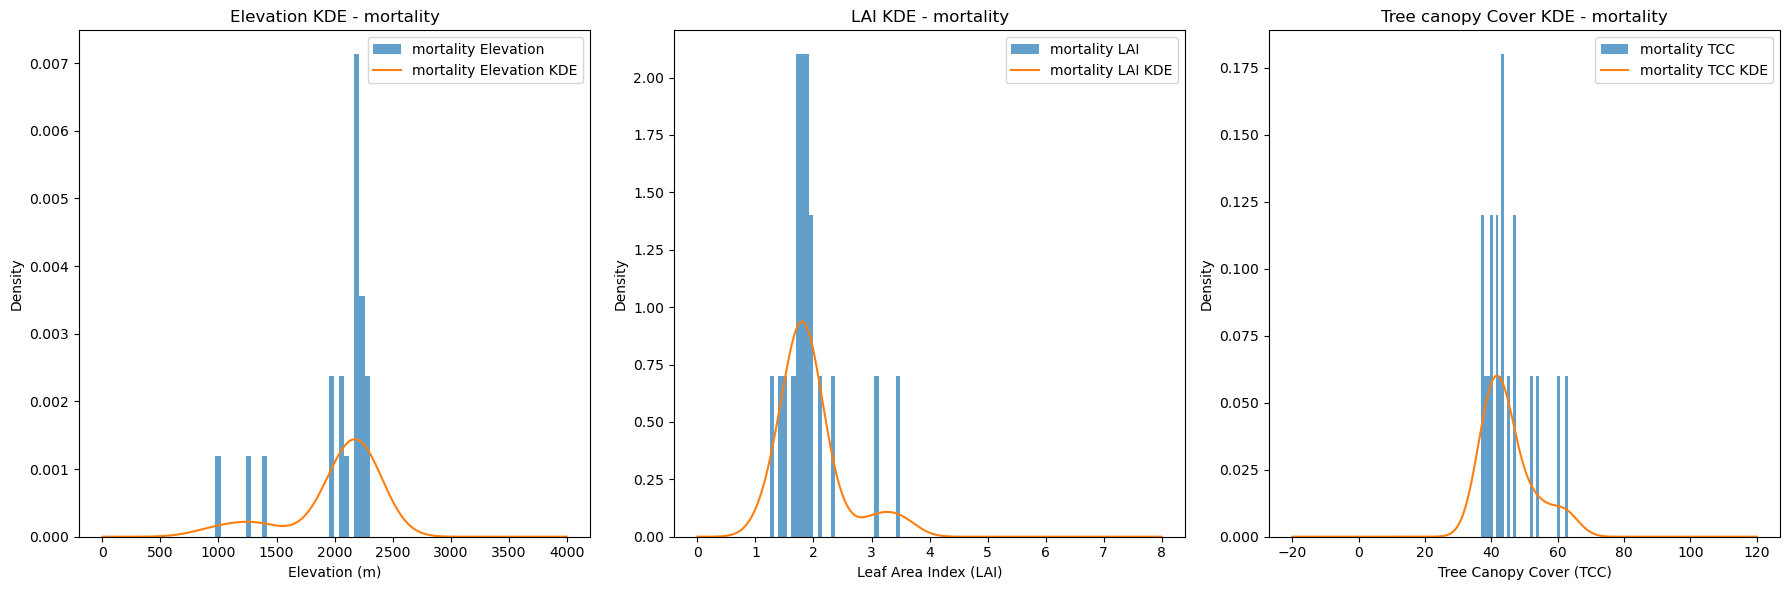

In [5]:
# Fit Kernel Density Estimators using gaussian_kde for all vars
elev_mortality_kde = gaussian_kde(elev_mortality_non_nan, bw_method = 'scott')
LAI_mortality_kde = gaussian_kde(LAI_mortality_non_nan, bw_method = 'scott')
TCC_mortality_kde = gaussian_kde(TCC_mortality_non_nan, bw_method = 'scott')

# Evaluate KDE for density estimation
elev_mortality_density = elev_mortality_kde.evaluate(elevation_range)
lai_mortality_density = LAI_mortality_kde.evaluate(LAI_range)
TCC_mortality_density = TCC_mortality_kde.evaluate(TCC_range)

# Fit Kernel Density Estimators using gaussian_kde for all vars
elev_control_kde = gaussian_kde(elev_control_non_nan, bw_method = 'scott')
lai_control_kde = gaussian_kde(LAI_control_non_nan, bw_method = 'scott')
TCC_control_kde = gaussian_kde(TCC_control_non_nan, bw_method = 'scott')

# Evaluate KDE for density estimation
elev_control_density = elev_control_kde.evaluate(elevation_range)
lai_control_density = lai_control_kde.evaluate(LAI_range)
TCC_control_density = TCC_control_kde.evaluate(TCC_range)


# Plot histograms and densities - Mortality
plt.figure(figsize=(18, 6))  # Adjust the figure size to accommodate 3 plots side by side
plt.subplot(1, 3, 1)
plt.hist(elev_mortality_non_nan, bins=30, alpha=0.7, label="mortality Elevation", density=True)
plt.plot(elevation_range, elev_mortality_density, label="mortality Elevation KDE")
plt.legend()
plt.title("Elevation KDE - mortality")
plt.xlabel("Elevation (m)")
plt.ylabel("Density")

plt.subplot(1, 3, 2)
plt.hist(LAI_mortality_non_nan, bins=30, alpha=0.7, label="mortality LAI", density=True)
plt.plot(LAI_range, lai_mortality_density, label="mortality LAI KDE")
plt.legend()
plt.title("LAI KDE - mortality")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Density")

plt.subplot(1, 3, 3)
plt.hist(TCC_mortality_non_nan, bins=30, alpha=0.7, label="mortality TCC", density=True)
plt.plot(TCC_range, TCC_mortality_density, label="mortality TCC KDE")
plt.legend()
plt.title("Tree canopy Cover KDE - mortality")
plt.xlabel("Tree Canopy Cover (TCC)")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


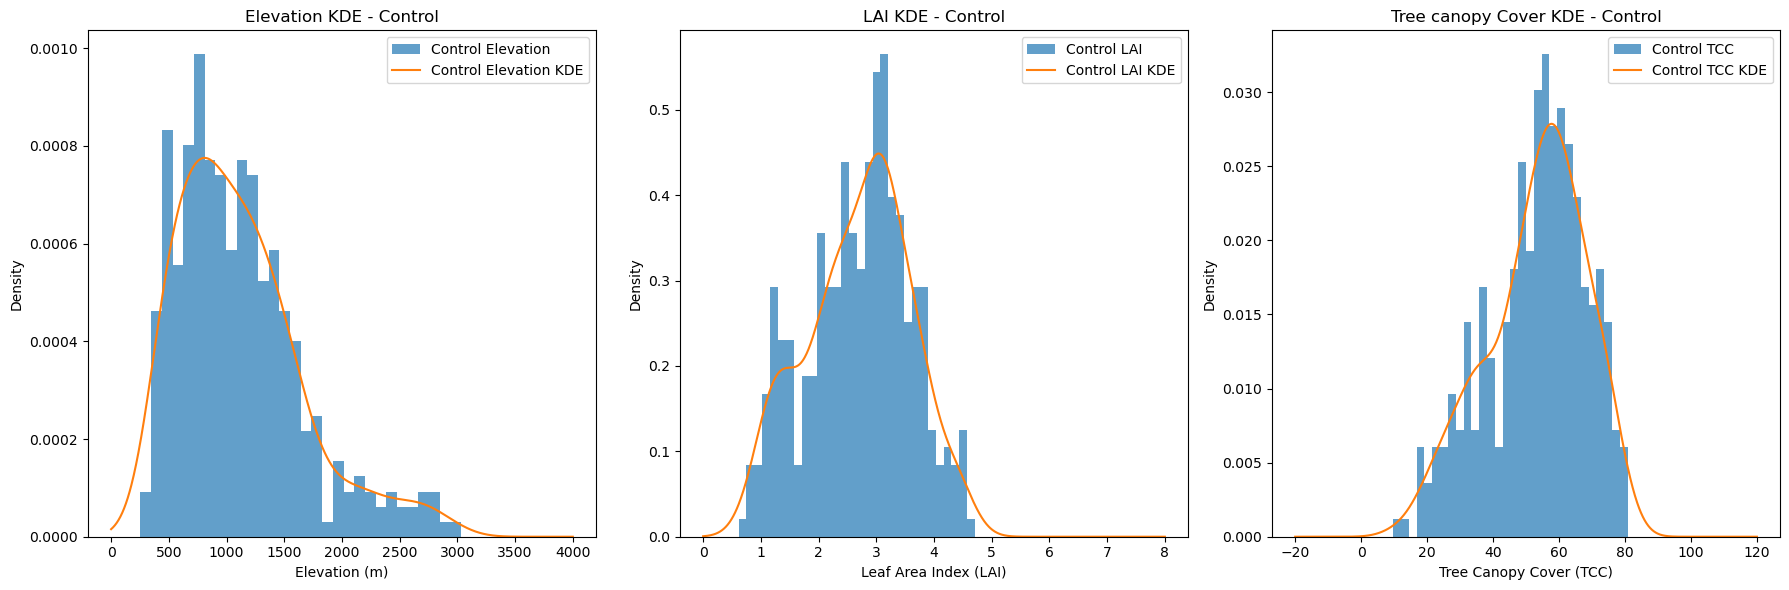

In [9]:
# Plot histgrams and densities - Control
plt.figure(figsize=(18, 6))  # Adjust the figure size to accommodate 3 plots side by side
plt.subplot(1, 3, 1)
plt.hist(elev_control_non_nan, bins=30, alpha=0.7, label="Control Elevation", density=True)
plt.plot(elevation_range, elev_control_density, label="Control Elevation KDE")
plt.legend()
plt.title("Elevation KDE - Control")
plt.xlabel("Elevation (m)")
plt.ylabel("Density")

plt.subplot(1, 3, 2)
plt.hist(LAI_control_non_nan, bins=30, alpha=0.7, label="Control LAI", density=True)
plt.plot(LAI_range, lai_control_density, label="Control LAI KDE")
plt.legend()
plt.title("LAI KDE - Control")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Density")

plt.subplot(1, 3, 3)
plt.hist(TCC_control_non_nan, bins=30, alpha=0.7, label="Control TCC", density=True)
plt.plot(TCC_range, TCC_control_density, label="Control TCC KDE")
plt.legend()
plt.title("Tree canopy Cover KDE - Control")
plt.xlabel("Tree Canopy Cover (TCC)")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

In [11]:
# Perform Kolmogorov-Smirnov test as a baseline to check whether the distributions are different
elevation_ks, elevation_ks_p = ks_2samp(elev_mortality_non_nan, elev_control_non_nan)
LAI_ks, LAI_ks_p = ks_2samp(LAI_mortality_non_nan, LAI_control_non_nan)
TCC_ks, TCC_ks_p = ks_2samp(TCC_mortality_non_nan, TCC_control_non_nan)
print('Initial Kolmogorov-Smirnov Test: Mortality vs. Control')
print('note: low p value (e.g. p < 0.05) indicates that the distributions are different')
print(f'Elevation p-value: {elevation_ks_p}')
print(f'LAI p-value: {LAI_ks_p}')
print(f'TCC p-value: {TCC_ks_p}')


Initial Kolmogorov-Smirnov Test: Mortality vs. Control
note: low p value (e.g. p < 0.05) indicates that the distributions are different
Elevation p-value: 2.6258392691375024e-11
LAI p-value: 3.72684374134412e-06
TCC p-value: 0.00017081678586711112


According to these tests, the control and mortality distributions are different for all three variables.

Now we will define a function which will implement a test of the KDE resampling filter using the list of control resample sizes defined above. This will plot the Kolmogorov-Smirnov p value for each resample size, and we can determine the optimal resample size for each variable.

In [10]:
#########################################
# Define KDE resampling function
#########################################

def test_KDE_resample_size(fit_elevation = True, fit_LAI = False, fit_TCC = False):

   # function start time
   start_time = time.time()

   # Initialize arrays to store p-values
   Elev_resample_v_mortality_p_samplesize_arr = []
   LAI_resample_v_mortality_p_samplesize_arr = []
   TCC_resample_v_mortality_p_samplesize_arr = []

   # Loop through control sample sizes
   for control_sample_size in control_sample_sizes:

      print(f'Control Sample Size: {control_sample_size}')
      Elev_resample_v_mortality_p_arr = []
      LAI_resample_v_mortality_p_arr = []
      TCC_resample_v_mortality_p_arr = []

      # Repeat the resampling process 100 times
      for _ in range(100):

         # Sample new values based on the densities (note, only those flagged by input booleans will be used)
         sampled_elev_values = elev_mortality_kde.resample(control_sample_size).flatten()
         sampled_lai_values = LAI_mortality_kde.resample(control_sample_size).flatten()
         sampled_TCC_values = TCC_mortality_kde.resample(control_sample_size).flatten()

         # Find indices in the control domain where both elevation and LAI match closely
         matching_indices = []
         control_polygon_gdf_KDE_FILTER = gpd.GeoDataFrame(columns=control_polygon_gdf.columns, crs=control_polygon_gdf.crs)
         for elev_val, lai_val, TCC_val in zip(sampled_elev_values, sampled_lai_values, sampled_TCC_values):
            # Calculate the normalized differences of each var
            elev_diffs = np.abs(elev_control_flat - elev_val)/elev_control_mean # divide by mean to normalize
            LAI_diffs = np.abs(LAI_control_flat - lai_val)/LAI_control_mean # divide by mean to normalize
            TCC_diffs = np.abs(TCC_control_flat - TCC_val)/TCC_control_mean # divide by mean to normalize
            
            # Combine constraints: find indices where combined differences are minimal
            overall_diffs = np.zeros(len(elev_diffs))
            if fit_elevation:
               overall_diffs += elev_diffs
            if fit_LAI:
               overall_diffs += LAI_diffs
            if fit_TCC:
               overall_diffs += TCC_diffs 

            matching_idx = np.nanargmin(overall_diffs) # identify the index of the minimum difference
            
            # Append the index if not already present (retains only unique pixels)
            if matching_idx not in matching_indices:
               matching_indices.append(matching_idx)

         # Convert the original indices to unique x/y coordinates
         sampled_coords = np.unravel_index(matching_indices, orig_dataset_shape)

         # Extract x and y coordinates as indices from the original datasets' grid
         sampled_x_icoords = sampled_coords[1]
         sampled_y_icoords = sampled_coords[0]

         # Loop through the sampled coordinates and recreate the gridded points where elevations were selected
         for ii in range(len(sampled_x_icoords)):
            x_coord = elev_rxr_control_clip.x.values[sampled_x_icoords[ii]]
            y_coord = elev_rxr_control_clip.y.values[sampled_y_icoords[ii]]

            # Find the closest point in control_polygon_gdf for each x, y coordinate pair
            distances = control_polygon_gdf.geometry.apply(lambda geom: geom.distance(gpd.points_from_xy([x_coord], [y_coord])[0]))
            closest_point_index = distances.idxmin()
            closest_point = control_polygon_gdf.loc[closest_point_index]
            
            # Filter control_polygon_gdf for points that are matched to these sets of coordinates
            control_polygon_gdf_KDE_FILTER = pd.concat([control_polygon_gdf_KDE_FILTER, closest_point.to_frame().T])

         # control_polygon_gdf_KDE_FILTER is now just like control_polygon_gdf but with a similar distrib to mortality pixels
         num_control_pixels = len(control_polygon_gdf_KDE_FILTER)

         # THIS IS OFFICIALLY WHERE BOOTSTRAP RESAMPLING WITH REPLACEMENT OCCURS
         # Randomly sample rows of the mortality_polygon_gdf object
         control_polygon_gdf_sampled = control_polygon_gdf_KDE_FILTER.sample(num_control_pixels, replace=True)

         # Extract the resampled values for each variable
         elevation_resample_select_values = elev_rxr_control_clip.elevation.rio.clip(control_polygon_gdf_sampled.geometry).values
         elevation_resample_select_values_flat = elevation_resample_select_values.flatten()
         elevation_resample_select_values_non_nan = elevation_resample_select_values_flat[~np.isnan(elevation_resample_select_values_flat)]

         TCC_resample_select_values = TCC_rxr_control_clip.tree_canopy_cover.rio.clip(control_polygon_gdf_sampled.geometry).values
         TCC_resample_select_values_flat = TCC_resample_select_values.flatten()
         TCC_resample_select_values_non_nan = TCC_resample_select_values_flat[~np.isnan(TCC_resample_select_values_flat)]

         lai_resample_select_values = LAI_rxr_control_clip.rio.clip(control_polygon_gdf_sampled.geometry).values
         lai_resample_select_values_flat = lai_resample_select_values.flatten()
         lai_resample_select_values_non_nan = lai_resample_select_values_flat[~np.isnan(lai_resample_select_values_flat)]
         
         # Perform Kolmogorov-Smirnov test to check whether the distribution of original vs. resampled are different
         elevation_ks, elevation_ks_p = ks_2samp(elevation_resample_select_values_non_nan, elev_mortality_non_nan)
         Elev_resample_v_mortality_p_arr.append(elevation_ks_p)
         TCC_ks, TCC_ks_p = ks_2samp(TCC_resample_select_values_non_nan, TCC_mortality_non_nan)
         TCC_resample_v_mortality_p_arr.append(TCC_ks_p)
         LAI_ks, LAI_ks_p = ks_2samp(lai_resample_select_values_non_nan, LAI_mortality_non_nan)
         LAI_resample_v_mortality_p_arr.append(LAI_ks_p)

      # take mean of p-values across all bootstrap repititions
      Elev_resample_v_mortality_p = np.mean(Elev_resample_v_mortality_p_arr)
      TCC_resample_v_mortality_p = np.mean(TCC_resample_v_mortality_p_arr)
      LAI_resample_v_mortality_p = np.mean(LAI_resample_v_mortality_p_arr)

      # append the mean p-values to the arrays, recording for this given resample size
      Elev_resample_v_mortality_p_samplesize_arr.append(Elev_resample_v_mortality_p)
      TCC_resample_v_mortality_p_samplesize_arr.append(TCC_resample_v_mortality_p)
      LAI_resample_v_mortality_p_samplesize_arr.append(LAI_resample_v_mortality_p)

   # Plot the results
   plt.figure(figsize=(12, 6))

   # add Shaded regions to denote what > or < 0.05 means
   plt.fill_between([0,1000], 0.05, 2, color='#018571', alpha=0.1, label="matches mortality distribution")
   plt.fill_between([0,1000], -1, 0.05, color='#a6611a', alpha=0.1, label="doesn't match mortality distribution")

   plt.axhline(y=0.05, color='black', linestyle='--', label='p = 0.05')
   plt.plot(control_sample_sizes, Elev_resample_v_mortality_p_samplesize_arr, label="Elevation p-value", marker='o')
   plt.plot(control_sample_sizes, LAI_resample_v_mortality_p_samplesize_arr, label="LAI p-value", marker='o')
   plt.plot(control_sample_sizes, TCC_resample_v_mortality_p_samplesize_arr, label="TCC p-value", marker='o')
   plt.xlabel("Control Sample Size")
   plt.ylabel("p-value")
   plt.xlim(min(control_sample_sizes)-10, max(control_sample_sizes)+10)
   plt.ylim(-0.01, np.max([Elev_resample_v_mortality_p_samplesize_arr, LAI_resample_v_mortality_p_samplesize_arr, TCC_resample_v_mortality_p_samplesize_arr])+0.1)
   plt.title(f"KDE-resampling: Kolmogorov-smirnov test pval vs. Control Sample Size\nFit elevation: {fit_elevation}, Fit LAI: {fit_LAI}, Fit TCC: {fit_TCC}")
   plt.legend()
   plt.grid(True)
   plt.show()

   end_time = time.time()
   print(f'function elapsed time: {timedelta(seconds=end_time-start_time)}')


Now let's test this by fitting various permutations of elevation, LAI and TCC KDEs:

Control Sample Size: 10
Control Sample Size: 30
Control Sample Size: 50
Control Sample Size: 70
Control Sample Size: 90
Control Sample Size: 110
Control Sample Size: 130
Control Sample Size: 150
Control Sample Size: 170
Control Sample Size: 190
Control Sample Size: 210


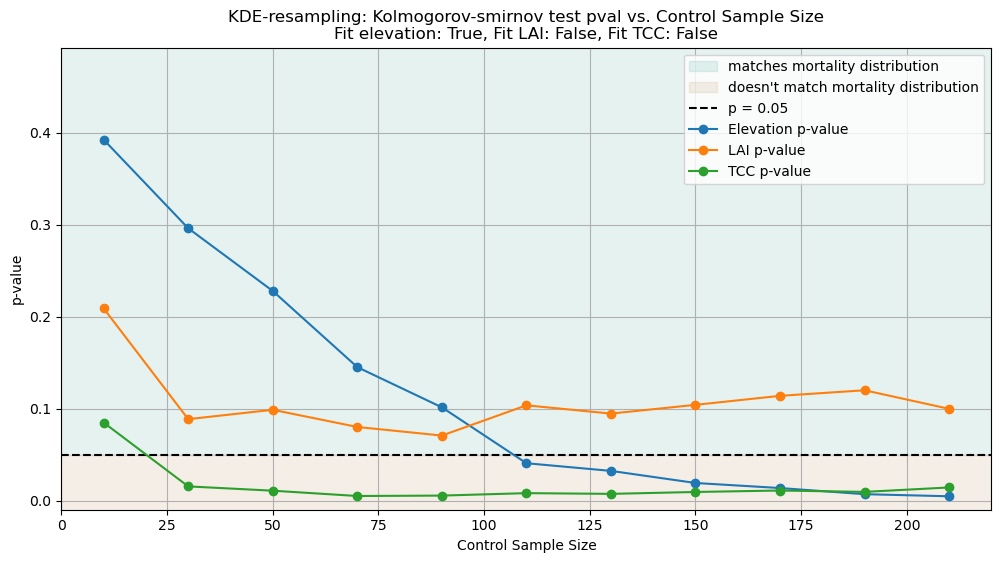

function elapsed time: 0:12:04.985031


In [11]:
# Test elevation-only KDE filter
test_KDE_resample_size(fit_elevation = True, fit_LAI = False, fit_TCC = False)

Control Sample Size: 10
Control Sample Size: 30
Control Sample Size: 50
Control Sample Size: 70
Control Sample Size: 90
Control Sample Size: 110
Control Sample Size: 130
Control Sample Size: 150
Control Sample Size: 170
Control Sample Size: 190
Control Sample Size: 210


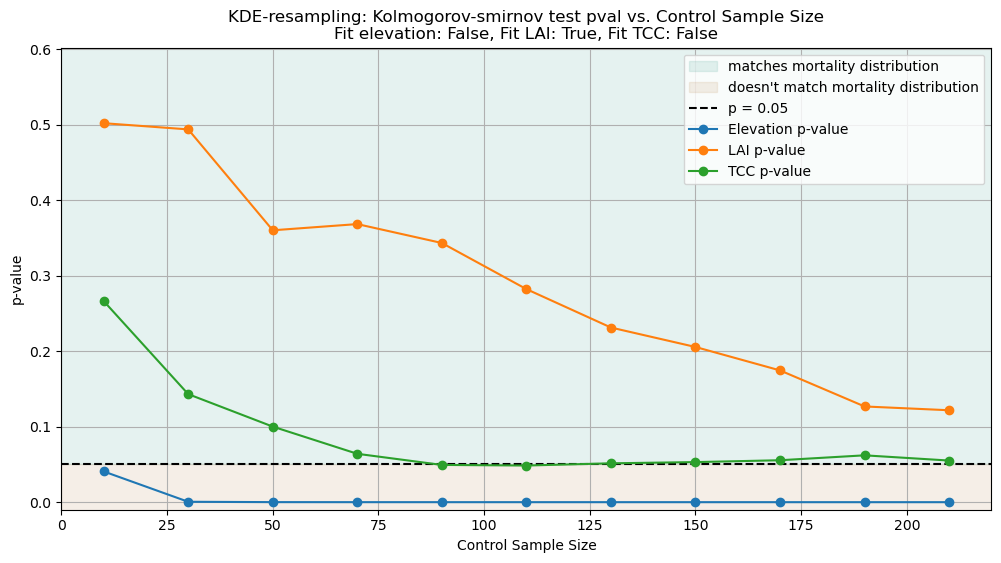

function elapsed time: 0:17:56.298892


In [12]:
# Test LAI-only KDE filter
test_KDE_resample_size(fit_elevation = False, fit_LAI = True, fit_TCC = False)

Control Sample Size: 10
Control Sample Size: 30
Control Sample Size: 50
Control Sample Size: 70
Control Sample Size: 90
Control Sample Size: 110
Control Sample Size: 130
Control Sample Size: 150
Control Sample Size: 170
Control Sample Size: 190
Control Sample Size: 210


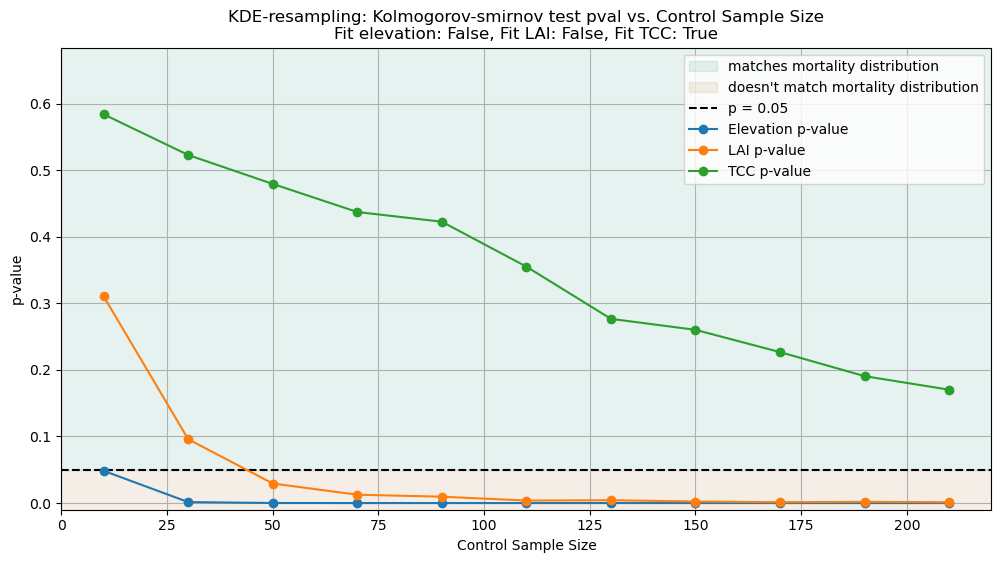

function elapsed time: 0:17:24.737790


In [13]:
# Test TCC-only KDE filter
test_KDE_resample_size(fit_elevation = False, fit_LAI = False, fit_TCC = True)

Control Sample Size: 10
Control Sample Size: 30
Control Sample Size: 50
Control Sample Size: 70
Control Sample Size: 90
Control Sample Size: 110
Control Sample Size: 130
Control Sample Size: 150
Control Sample Size: 170
Control Sample Size: 190
Control Sample Size: 210


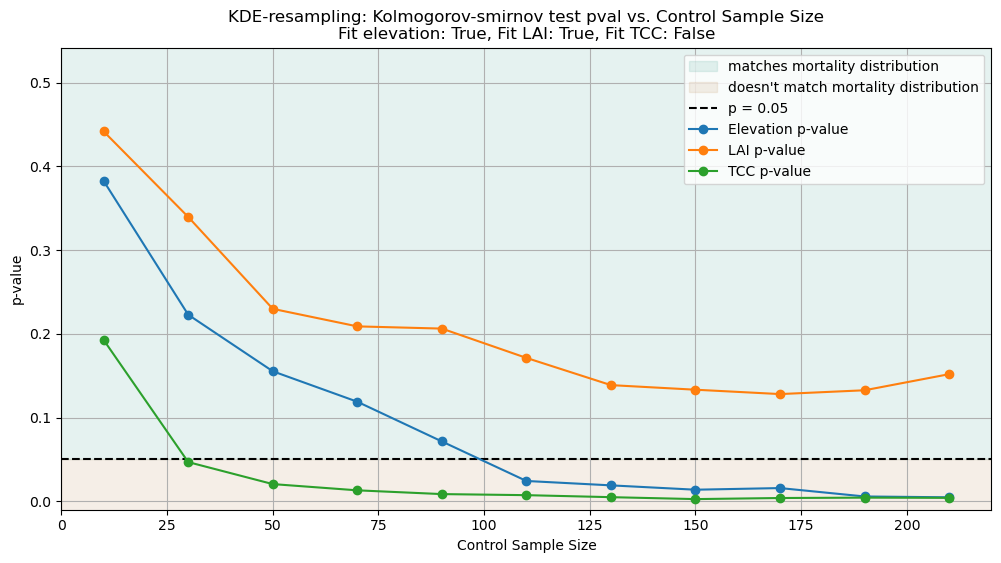

function elapsed time: 0:10:30.035979


In [14]:
# Test elevation and LAI KDE filter
test_KDE_resample_size(fit_elevation = True, fit_LAI = True, fit_TCC = False)

Control Sample Size: 10
Control Sample Size: 30
Control Sample Size: 50
Control Sample Size: 70
Control Sample Size: 90
Control Sample Size: 110
Control Sample Size: 130
Control Sample Size: 150
Control Sample Size: 170
Control Sample Size: 190
Control Sample Size: 210


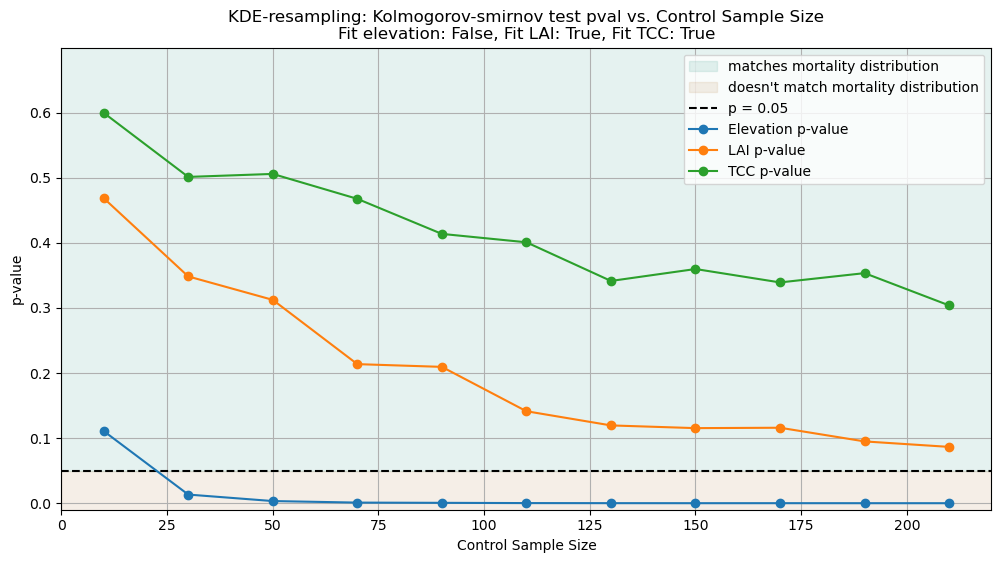

function elapsed time: 0:12:10.345379


In [15]:
# Test LAI and TCC KDE filter
test_KDE_resample_size(fit_elevation = False, fit_LAI = True, fit_TCC = True)

Control Sample Size: 10
Control Sample Size: 30
Control Sample Size: 50
Control Sample Size: 70
Control Sample Size: 90
Control Sample Size: 110
Control Sample Size: 130
Control Sample Size: 150
Control Sample Size: 170
Control Sample Size: 190
Control Sample Size: 210


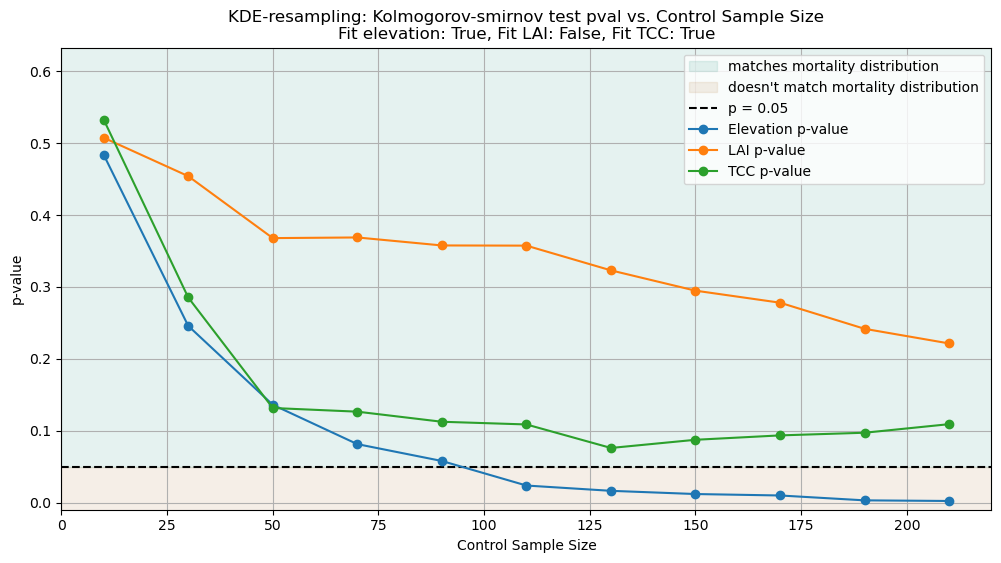

function elapsed time: 0:09:54.011706


In [16]:
# Test elevation and TCC KDE filter
test_KDE_resample_size(fit_elevation = True, fit_LAI = False, fit_TCC = True)

Control Sample Size: 10
Control Sample Size: 30
Control Sample Size: 50
Control Sample Size: 70
Control Sample Size: 90
Control Sample Size: 110
Control Sample Size: 130
Control Sample Size: 150
Control Sample Size: 170
Control Sample Size: 190
Control Sample Size: 210


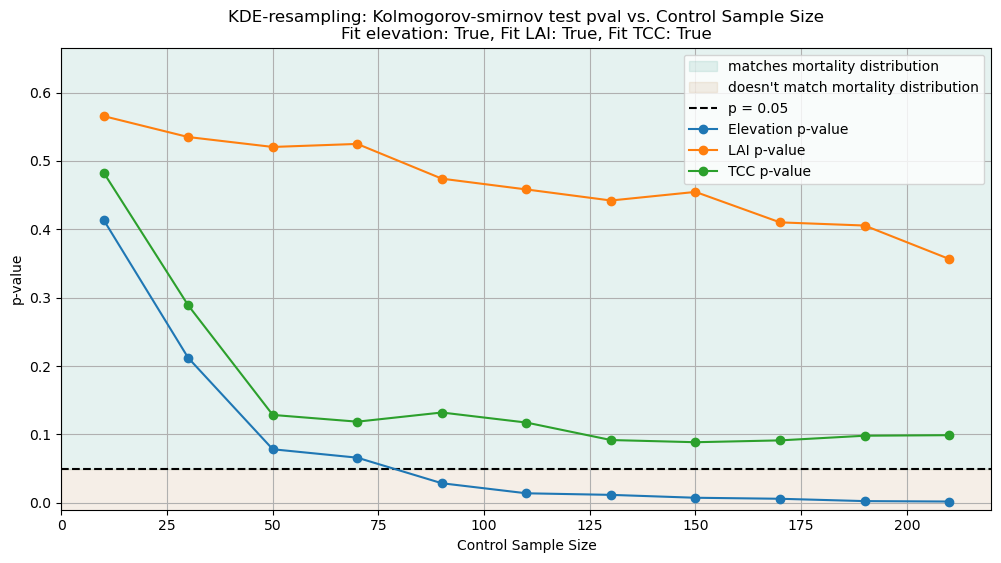

function elapsed time: 0:09:30.455500


In [17]:
# Test all three variables used in KDE filter
test_KDE_resample_size(fit_elevation = True, fit_LAI = True, fit_TCC = True)